# Constructing the Method of Moment Matrix
# by Allowing ForwardDiff to Operate on QuadGK Output 

## Import Packages

In [134]:
using ForwardDiff
using QuadGK
using Plots 

## Section 1: Introduction 
<b>Motivation</b> We wish to generate the MoM matrix as the linear transformation matrix (sensitivity matrix, input-output matrix) mapping magnetization vector $\vec{M}(\vec{x})$ to the magnetic flux vector $\vec{B}(\vec{x})$ after spatial discretization (need to include magnetic field $\vec{H}(\vec{x})$). In the following, we make this idea more precise. 

Assume a 3D computational domain $\vec{x} \in \Omega$ with a subset $\Omega_M$ on with the magnetic sources are defined. In a continuous setting (i.e. prior to spatial discretization), we have that the magnetic vector potential $\vec{A}(\vec{x})$ depends on the magnetization vector $\vec{M}(\vec{x})$ via a [Biot-Savart](https://en.wikipedia.org/wiki/Biot–Savart_law) type relation 
$$\vec{A}(\vec{x}) = \frac{\mu_0}{4 \pi} \int_{\Omega_m} 
                \frac{\vec{M}(\vec{x}') \times (\vec{x}-\vec{x}')}{|\vec{x}-\vec{x}'|^3} \, d\vec{x}' \, . $$    The magnetic flux $\vec{B}(\vec{x})$ is then obtained via 
$$ \vec{B}(\vec{x}) = \nabla \times \vec{A}(\vec{x}) \, . $$

A mesh $\Omega^h$ on $\Omega$ with $N$ nodes is defined. The numerical approximation to vector $\vec{M}(\vec{x})$ is expressed as a linear combination on shape function (or basis functions) as (three components of $\vec{M}^h(\vec{x}$ expressed in the same linear nodal first order Lagrange basis functions, the summation upper therefore denoted by $3N$)
$$ \vec{M}(\vec{x}) \thickapprox \vec{M}^h(\vec{x})= \sum_{i=1}^{3N} m_i \, \phi_(\vec{x}) \, .$$ 
Replacing $\vec{M}(\vec{x})$ by $\vec{M}^h(\vec{x})$ in the expression for $\vec{A}(\vec{x})$ yiels the numerical approximation $\vec{A}^h(\vec{x})$. Similarly, replacing $\vec{A}(\vec{x})$ by $\vec{A}^h(\vec{x})$ in the expression for $\vec{B}(\vec{x})$, yiels the numerical approximation $\vec{B}^h(\vec{x})$. Let $\vec{m}$ denote the $3N$-vector of expansion coefficients of $\vec{M}^h(\vec{x})$ in the basis of $\phi_i{(\vec{x})}$ basis functions. Let $\vec{a}$ and $\vec{b}$ denote the $3N$-vectors obtained by point-matching the relationships that define them. Then clearly both $\vec{a}$ and $\vec{b}$ are vector-valued functions with $3N$ components that map $\vec{m}$ to $\vec{a}(\vec{m})$ and $\vec{b}(\vec{m})$, respectively. We can thus write formally that $\vec{a}: \vec{m} \in R^{3N} \rightarrow \vec{a}(\vec{m}) \in R^{3N}$ and  
$\vec{b}: \vec{m} \in R^{3N} \rightarrow \vec{b}(\vec{m}) \in R^{3N}$. The Jacobian of mapping 
$\partial b_i / \partial m_j$ is the MoM matrix. We wish to develop a procedure that compute this Jacobian by going through the following two steps: 
1. apply (adaptive) quadrature (including handling of singular integrals) to compute the mapping $\vec{a}(\vec{m})$, i.e., a vector function of $3N$ components $a_i$ that each depend on the $3N$ vector $\vec{a}$;  
2. apply automatic differentiation to differentiate (compute the Jacobian) the magnetic flux $\vec{b}(\vec{m}) = \vec{b}(\vec{a}(\vec{m})))$ wrt to $\vec{m}$ to obtain the MoM matrix;

The above ideas are borrowed from non-linear FEM analysis is which Jacobian is formed from the residual vector. More details of both steps will be outlined below. These steps focuss on the <b>generation</b> MoM matrix. Solving of the linear system with the MoM will be discussed elsewhere.

<b>Proof of Concept</b>
Below we give a proof of concept of composing quadrature and automatic differentiation. This examples assummes a one-dimensional domain and uses smooth (harmless) integration kernel. More effort is required to treat singular kernels in three-dimensional computational domains (as required in MoM). 

In [137]:
# define the vector potential density as magnetization times kernel 
magnetization(x,m) = m[1]*sin(π*x)+m[2]*cos(π*x) 
kernel(x,xp) = (x-xp)
vpdens(x,xp,m) = magnetization(xp,m)*kernel(x,xp)

# define the vector potential by integrating in the integration variable xp over the magnetization domain  
vp(x,m) = quadgk(xp -> vpdens(x,xp,m), 0, 1)

# define the magnetic flux as the partial derivative of the potential wrt x (keeping m fixed)
bflux(x,m) = ForwardDiff.derivative(x -> vp(x,m)[1],x)

## sampling points in x (space) and m (coefficients of the expansion on magnetization in the function basis) 
xx = [.25, .75]
mm = [1., 2.]

# collocate the field on the grid in x - do point matching 
# observe depency in m remains 
bfluxsamp(m) = [bflux(xi,m) for xi in xx]

# compute the Jacobian  
ForwardDiff.jacobian(bfluxsamp, mm) 

2×2 Matrix{Float64}:
 0.63662  3.77101e-17
 0.63662  3.77101e-17

 <b>Potential Gains</b> We perceive the following gains 
1. allow automatic differentiation to perform half the work. We can thus focus on the remaining part of the work. (do we need to pay a price (toll) later? We need to ensure that in performing the integral computation over xprime, the result remains differentiable wrt x); 
2. preserve order of computations as the math reads, i.e., first integration of the source domain, then differentiate in the destination variables. Code thus easier to read and maintain?;
3. avoid differentiating the integral, thus avoid increasing the singularity of the integrand? 
4. avoid splitting integral as a sum of multiple integrals (and thus simplify the overall bookkeeping); 
5. avoid replacing volume integrals $dx'\,dy'\,dz'$ over elements $e_k$ in the finite element mesh as sum of integrsals over faces of $e_k$ (how to compute singular integrals over tetrahedra?); 
6. allow for more general basis functions; 
7. extend to non-linear constitutive relations (as similar ideas apply);   
8. show-case distinct use of multiple dispatch allowing to compose two Julia packages (cfr. earlier case of combined used of interval arithmetic and ODE solver by Chris Raukaucas);  

<b>Assumptions Made</b> We assume (falsily?) that 
1. the eventual computational overhead of adaptive quadrature (for singular intregrals on tetrahedra) can be amortized by thread-parallel computations (as shown earlier by the heroin in this project);
2. residual weighting of the MoM equations (weak or variational formulations) occurs using Dirac delta (pulse) functions (distribution). Residual weighting thus reduces to point matching;
3. adaptive quadrature carries over from 1D (only x) to 2D (xy) and 3D (xyz); 

<b>One-Dimensional Case</b> In one spatial dimension ($x$-only), the vector valued problem reduces to a scalar problem. Given the magnitization vector $\vec{M}(\vec{x}) = (0,0,M_z(x))$, we wish to compute (confusing noation: rectify by specifying what $\Omega$ and $\Omega_m$ are)
1. the magnetic vector potential $\vec{A}(\vec{x}) = (0,A_y(x),0)$ where 
$A_y(x) = \frac{\mu_0}{4 \pi} \int_a^b \frac{M_z(x') \, (x-x')}{|x-x'|^3} \, dx'$ using quadrature implemented in QuadGK.jl; 
2. the magnetic flux $\vec{B}(\vec{x}) = (0,0,B_z(x))$ where $B_z(x) = - \frac{\partial A_y(x)}{\partial x}$ using automatic differentiation implemented in ForwardDiff.jl;  

<b>Spatial Discretization of the One-Dimensional Case</b> Introduce computational mesh $\Omega^h$ of $N$ elements $e_k = [x_k, x_{k+1}]$ and $N+1$ nodes $x_i$ on the domain of computation $\Omega$. On $e_k$ linear nodal shape function $\phi_i(x)$ can be defined. Express numerical approximation to $M_z(x)$ as $M^h_z(x) = \sum_i m_i \, \phi_i(x)$. Denote $\vec{m}$ the (N+1)-dimensional vector (one per node) of the mesh. Replacing $M_z(x)$ as $M^h_z(x)$ in the expression for $A_y(x)$ yields $A^h_y(x)$. The evaluation of $A^h_y(x)$ in the nodes $x_i$ yields a (N+1)-dimensional vector $\vec{a}$. This vector depends on $\vec{m}$. We thus write $\vec{a}(\vec{m})$. Given its importance in later discussions, we emphasize the point by formulating $\vec{a}$ as a mapping from $R^{N+1}$ to $R^{N+1}$ mapping $\vec{m}$ to $\vec{a}(\vec{m})$. A similar discourse holds for $B_z(x)$ by first differentiating $A^h_y(x)$ wrt to $x$ and then point-evaluation (order obviously matters here). We again obtain a mapping from $R^{N+1}$ to $R^{N+1}$ mapping $\vec{m}$ this time to $\vec{b}[\vec{a}(\vec{m})]$. The Jacobian of this mapping wrt $\vec{m}$ is the much desired $(N+1)-by-(N+1)$ MoM matrix.   

<b>Resulting Algorithm for a Forward Computation</b>

1. Generate mesh of $\Omega$
2. Generate set basis functions 
3. (to be extended) 

<b>Three-Dimensional Mesh Generation</b> To be discussed.

<b>Spatial Discretization of the Three-Dimensional Case</b> To be discussed. 

<b>Julia Packages Used</b>
We will use the following two packages: 
1. [QuadGK.jl](https://juliamath.github.io/QuadGK.jl/stable/) for adaptive quadrature (requires context on quadrature (adaptive and non-adaptive) on meshes in Julia - ask our heroin for first draft); 
2. [ForwardDiff.jl](https://juliadiff.org/ForwardDiff.jl/stable/) for automatic differentiation (requires context on automatic (forward mode and backward mode) differentiation in Julia - ask our heroin for first draft); 

The magic resides in the multiple dispatch that allows to chain QuadGK.jl and ForwardDiff.jl.

<b>Related Packages</b> 

- [Meshes.jl](https://juliageometry.github.io/MeshesDocs/stable/) and related Zulip channel; 
- [MeshIntegrals.jl](https://github.com/mikeingold/MeshIntegrals.jl) 

<b>How to Procede from Here?</b>
1. replace implementation that employ an array of function to code the basis function by common loop over elements; 
2. extend to 2D

<b>References</b> (ask our heroin to expand) 
1. Book Roman Szewczyk (Springer LNEE 491 2018)
2. Caorsi, Moreno and Sidoti, 1993: test case of block profile in Figure 4; 

<b>Notation</b> We use the following notation: 
- xp for xprime; 
- vpdens for vector potential density;
- vp for vector potential; 
- $k$ and $ell$: outer loop over elements (k) and DOF per element (ell); 
- $m$ and $n$: outer loop over elements (m) and DOF per element (n); 
- i: loop over nodes; 

## Section 1.1: Basis functions in 1D (sandbox)

In [142]:
# generate the mesh 
N = 99; h = 1/N; Np1 = N+1; 
xvec = Vector(0:h:1)

basisfcts = Array{Function}(undef, Np1)
basisfct(x,xvec,i) =  (x-xvec[i-1])*(1/(xvec[i]-xvec[i-1]))*(x>=xvec[i-1])*(x<xvec[i]) + (xvec[i]-x)*(1/(xvec[i+1]-xvec[i]))*(x>=xvec[i])*(x<xvec[i+1])
for k=2:N
   vparray[k] = x -> basisfct(x,xvec,k) 
end 

## Section 2.1: Singular Integrals (sandbox)

The thing is that as long as r∉∂V, the integrand is a differentiable function, so standard refinement eventually works fine.

But to make it even better, if Fi are the faces of the cube, for each i, you look for the r∗i∈Fi that is closest to r, this is where the almost singularity will be. Then divide the face in 4 sections, where r∗ is the point of intersection of this 4 sections. Now you have 4 integrals that they have almost-singularities in one corner.

Replacing the volume integral over a cell by a set of surface integrals over the faces to allow a better grip on the singularity. Operations on 3D mesh thus required: 
1. retrieve faces belonging to a cell;
2. subdivide a face;
3. compute distance to nearest vertex; 

## Section 2: QuadQK, ForwardDiff and Their Combined Use 

### Section 1.2: Examples of QuadQK 
Small example of QuadQK. Singular integrals on purpose avoided (see next Section). Outputs integral value and error. Morer later (amount of function evaluations). 

In [2]:
# define single input integrand
integrand(x) = x^2 

I = quadgk(x -> integrand(x), 0, 1)

(0.3333333333333333, 0.0)

### Section 2.2: Examples of ForwardDiff for Scalar Case 
Small examples of ForwardDiff. More later (Jacobian and preallocating memory for dense Jacobian). 

In [3]:
ForwardDiff.derivative(x -> x^3, 1)

3

### Section 3.2: Examples of ForwardDiff for Vector-Valued Case
Can we re-formulate this example by reformulating the computation of $r[i]$ as 
$r[i] = \int_{x_{i-1}}^{x_{i+1}} u'_h(x) \, \phi'_i(x) \, dx $? 

In [4]:
function residual(m)
    r = similar(m)
    r[1] = m[1]
    for i=2:length(m)-1
        r[i] = -m[i-1] + 2*m[i] - m[i+1] 
    end 
    r[end] = m[end]
    return r
end

residual (generic function with 1 method)

In [5]:
m = ones(5)
r = residual(m)
display(r)

5-element Vector{Float64}:
 1.0
 0.0
 0.0
 0.0
 1.0

In [6]:
ForwardDiff.jacobian(residual, m) 

5×5 Matrix{Float64}:
  1.0   0.0   0.0   0.0   0.0
 -1.0   2.0  -1.0   0.0   0.0
  0.0  -1.0   2.0  -1.0   0.0
  0.0   0.0  -1.0   2.0  -1.0
  0.0   0.0   0.0   0.0   1.0

### Sectiion 4.2: Example of Derivate of an Integral 
Small example of derivative of an integral. More later. 

In [7]:
# define two input integrand
integrand(x,xp) = x - xp

# compute integral by quadrature over second input - results in u(x) = x - 0.5
u(x) = quadgk(xp -> integrand(x,xp), 0, 1)

# compute derivative - should result in du/dx = 1
ForwardDiff.derivative(x -> u(x)[1], 1)

1.0

## Section 3: QuadQK for Singular Integrals  
The following example was constructed to illustrate difficulties with singular kernels. See [QuadQK.jl](https://juliamath.github.io/QuadGK.jl/stable/) for treating singular integrals.  

In [125]:
# define two input integrand
integrand(x,xp) = (x-xp)/abs(x - xp)^1.5

# compute integral by quadrature over second input
u(x) = quadgk(xp -> integrand(x,xp), 0, 1)

# compute derivative - should result in du/dx = 1
ForwardDiff.derivative(x -> u(x)[1], 1)

-9.514789506324105e7

Please <b>observe</b> that in the previous cell the function $u(x)$ is <b>never</b> evaluated. This is particulary interesting, as we can evaluate $u(x)$ for $x$ such that $0 < x < 1$ (i.e. $x$ not coinciding with bounds of domain of integration, and integrand singular in the interior of the interval) (quadrature fails) and $x=1$ (i.e. $x$ coinciding with upper integration bound) (quadrature works).  

In [126]:
u(0.9)

LoadError: DomainError with 0.8999999999999986:
integrand produced NaN in the interval (0.8999999999999915, 0.9000000000000057)

In [127]:
u(1)

(1.9999999875459993, 2.6379133460101236e-8)

## Section 4: Explicit (or Direct) Construction - Assume Magnetic Sources Known - Compute Magnetic Vector Potential A_y and Magnetic Flux B_z 
Here we assume that the magnetization is a given block profile. We compute the vector potential component and the magnetic flux component. Results in this section can be verified by solving the one-dimensional Poisson equation for the scalar magnetic vector potential ($\phi_m$ such that $\vec{H} = \nabla \phi_m$). This can easily be accomplished using a shooting method for the boundary value problem. Such a shooting method is implemented in DifferentialEquations.jl. See the EE4375 course for example. 

### Section 4.1: Assume $M_z(x) = 1$ between $x=0.4$ and $x=0.6$: First Alternative 
This construction fails as quadgk is unable to treat the singular kernel without guidance. 

In [34]:
# define two input integrand
a = 0.4; b = 0.6; 
magnetization(x) = ((x>a)*(x<b))
kernel(x,xp) = (x-xp)/abs(x - xp)^3
vpdens(x,xp) = magnetization(xp)*kernel(x,xp)

# compute integral by quadrature over second input 
# observe the integration bounds 
vp(x) = quadgk(xp -> vpdens(x,xp), 0, 1)

# compute flux as x-derivative of potential  
bflux(x) = ForwardDiff.derivative(x -> vp(x)[1])

# generate plot 
N = 100; h = 1/N; 
xs = Vector(0:h:1)
ms = magnetization.(xs)
vps = vp.(xs)
bfluxs = bflux.(xs)

p1 = plot(xs, ms)
p2 = plot(xs, vps)
p3 = plot(xs, bfluxs)
plot(p1,p2,p3,layout=(1,3))

LoadError: DomainError with 0.4499999999999993:
integrand produced NaN in the interval (0.44999999999999574, 0.45000000000000284)

### Section 4.2: Assume $M_z(x) = 1$ between $x=0.4$ and $x=0.6$: Second Alternative 
Guide quadgk in performing integration of singular kernel by divide-and-conquer. We apply a mesh on the interval $\Omega = (0,1)$, perform integration on each element on the mesh and evaluate the integral on the nodes of the mesh. In this way we ensure that <b>singularity of integrand is always on the boundary of the integration domain</b>. 

We evaluate the vector potential component as a sum of contributions per element 

$A_y(x) = \frac{\mu_0}{4 \pi} \int_0^1 \frac{M_z(x) \, (x-x')}{|x-x'|^{3}} \, dx' 
        = \frac{\mu_0}{4 \pi} \sum_{k=1}^{N} \int_{x_k}^{x_{k+1}} \frac{M_z(x) \, (x-x')}{|x-x'|^{3}} \, dx' $

In [128]:
# define two input integrand
a = 0.4; b = 0.6; 
a = 0.; b = 1.; 
magnetization(x) = ((x>a)*(x<b))
kernel(x,xp) = (x-xp)/abs(x - xp)^1.5
vpdens(x,xp) = magnetization(xp)*kernel(x,xp)
 
# generate the mesh 
N = 99; h = 1/N; Np1 = N+1; 
xvec = Vector(0:h:1)

vparray = Array{Function}(undef, N)
# compute integral by quadrature over second input over all elements [x_k, x_{k+1}]
# observe syntax used to define an array of functions 
for k=1:N
   vparray[k] = x -> quadgk(xp -> vpdens(x,xp), xvec[k], xvec[k+1])[1]
end 

bfluxarray = Array{Function}(undef, N)
# compute bflux as x-derivative over all elements of vparray 
# observe syntax used to define an array of functions 
for k=1:N
  bfluxarray[k] = x -> ForwardDiff.derivative(x -> vparray[k](x)[1],x)
end 

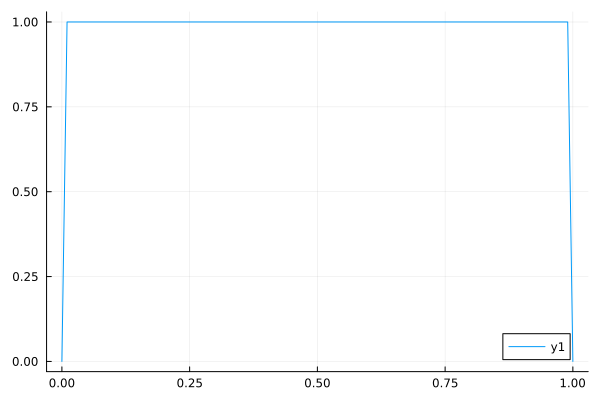

In [129]:
plot(xvec, magnetization.(xvec))

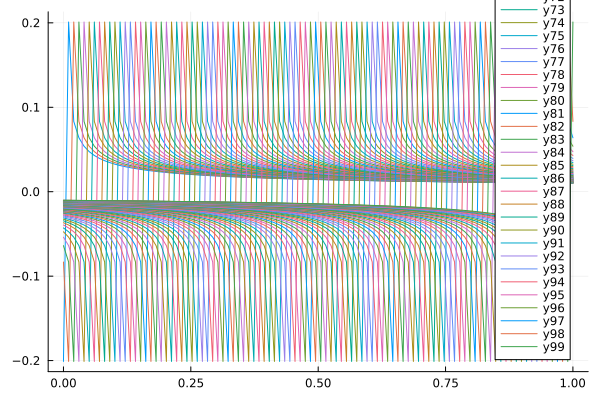

In [130]:
plot(xvec,[vparray[k].(xvec) for k=1:N])

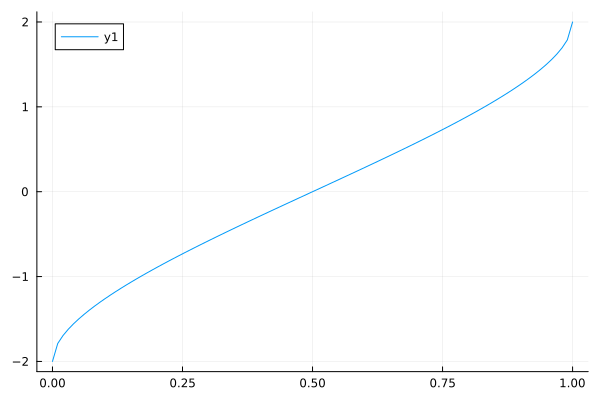

In [131]:
# evaluate vector potential as sum of contribution over N elements 
vparrayvec = sum([vparray[k].(xvec) for k=1:N],dims=1)
plot(xvec,vparrayvec)

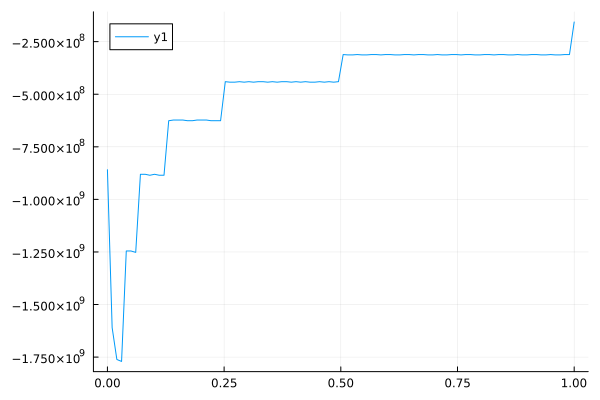

In [132]:
bfluxarrayvec = sum([bfluxarray[k].(xvec) for k=1:N],dims=1)
plot(xvec,bfluxarrayvec)